<a href="https://colab.research.google.com/github/evalevanto/2020submissions/blob/master/satelite_imagery_classification_with_LLaVA_7B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

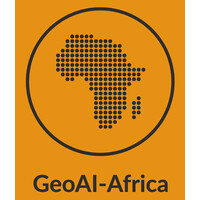

# [Indaba 2024] GeoAI Africa Workshop
## Challenge: Land Cover Classification using VLMs

### Motivation
The Indaba GeoAI Competition seeks to explore the use of VLMs on auto-labelling datasets for land cover classification in Africa.

### Task
Multilabel classification task. Participants will use VLMs to automatically generate labels for satellite imagery.

**Goal**: Identify and rank land cover classes in satelite imagery.
```
Land cover classes
---
0: Forest
1: Water
2: Cropland
3: Buildings
4: Road
```

### Dataset
TODO: What data do we provide?
#### Train
Count: TODO
Format: Folder: RGB satellite images(filenames:image_id). CSV: image_id, label
Label: array sorted by dominance in land cover class.
#### Test
Count: TODO
Format: Folder: RGB satelite images(filenames:image_id)

# Running Llava

Llava is a multi-modal image-text to text model that can be seen as an "open source version of GPT4".

![image/png](https://cdn-uploads.huggingface.co/production/uploads/62441d1d9fdefb55a0b7d12c/FPshq08TKYD0e-qwPLDVO.png)

The architecutre is a pure decoder-based text model that takes concatenated vision hidden states with text hidden states.

We will leverage QLoRA quantization method and use `pipeline` to run our model.

In [ ]:
# install packages
!pip install -q -U transformers==4.37.2
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0

## Load an image

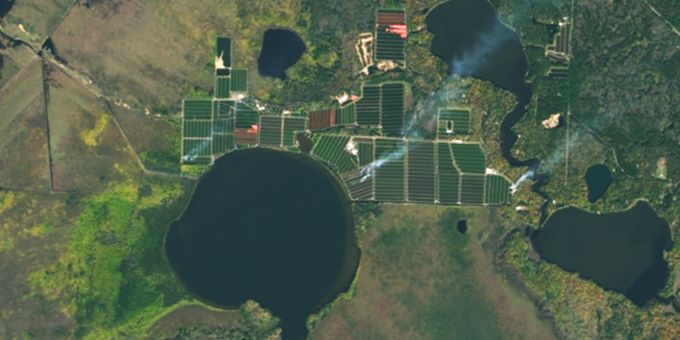

In [ ]:
import requests
from PIL import Image

image_url = "https://www.agritechtomorrow.com/images/articles/12102.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
image

## Preparing the quantization config to load the model in 4bit precision

In order to load the model in 4-bit precision, we need to pass a `quantization_config` to our model. Let's do that in the cells below

In [ ]:
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

## Load the model using `pipeline`

We will leverage the `image-to-text` pipeline from transformers !

In [ ]:
from transformers import pipeline

# llava-hf/llava-v1.6-mistral-7b-hf
model_id = "llava-hf/llava-1.5-7b-hf"

pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

It is important to prompt the model wth a specific format, which is:
```bash
USER: <image>\n<prompt>\nASSISTANT:
```

In [ ]:
max_new_tokens = 200
prompt = "SYSTEM: You are a helpful image analyst that specializes in satellite and aerial images. You always truthfully answer the user’s question. If you are not sure about something, don’t answer false information.\nUSER: <image>\nGiven the following land cover classes: Water, crop, forest, buildings. Output a list that is sorted by the most common occuring land cover in the image.\nASSISTANT:"

outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

In [ ]:
print(outputs[0]["generated_text"])

SYSTEM: You are a helpful image analyst that specializes in satellite and aerial images. You always truthfully answer the user’s question. If you are not sure about something, don’t answer false information.
USER:  
Given the following land cover classes: Water, crop, forest, buildings. Output a list that is sorted by the most common occuring land cover in the image.
ASSISTANT: The most common land cover in the image is the crop land, which is found in the form of a large field. The other land cover classes, such as water, forest, and buildings, are less common and appear in smaller areas within the image.
